<h1>Experiment 3: ChordTuplev2 Encoding Predictions</h1>

<h3>Dependencies and setup</h3>

In [1]:
import sys
sys.path.append('/root/project/venv/lib/python3.7/site-packages')
import music21, miditoolkit
import chord_preprocess2 as chord_preprocess
from copy import deepcopy

In [2]:
# Load model
from fairseq.models.roberta import RobertaModel
from fairseq import utils
roberta = RobertaModel.from_pretrained(
    '.',
    checkpoint_file="final_checkpoints/chordtuple_2_best_noCT_noRED_musicbert_small.pt", # for chordtuples
    data_name_or_path="chordtuple_2_noCT_noRED_data_bin",
    user_dir="musicbert"
).cuda()

disable_cp = False
mask_strategy = ['bar']
convert_encoding = OCTMIDI
crop_length = None


In [3]:
def fill_masks(oct_str, topk=1):
    src_dict = roberta.task.source_dictionary
    
    # Encode line
    tokens = src_dict.encode_line(
        oct_str,
        append_eos=False,
        add_if_not_exist=False
    )
    
    if tokens.dim() == 1:
        tokens = tokens.unsqueeze(0)
    
    # Actual prediction
    with utils.model_eval(roberta.model):
        features, extra = roberta.model(
            tokens.long().to(device=roberta.device), 
            features_only=False, 
            return_all_hiddens=False
        )
    
    masked_index = (tokens == roberta.task.mask_idx).nonzero()
    masked_index = masked_index[:, 1:]
    # print(f"Masked index: {masked_index}")
    
    
    logits = features[0, masked_index, :].squeeze()
    probs = logits.softmax(dim=0)
    
    
    # Fetch top k predictions
    values, index = probs.topk(k=topk, dim=1)
    
    # Locate predictions in dict and return
    pred_toks = []
    for top_ks_ind in index:
        top = src_dict.string(top_ks_ind).replace("\n", " ").split(" ")
        pred_toks.append(top)
        
    # print(f"Predictions: {pred_toks}")
    return pred_toks

In [4]:
# Predicting using ChordTuple Encoding
## COMPLETE GIVEN CHORD PROGRESSION
from copy import copy
import re, music21
def complete_chord_prog_chordtuple(chords, 
                                   mask_start, mask_end, inst, topk=5, midi=None, 
                                   pitchrange=(0, 127), plot=False, return_pitchnums=False, log=True):
    min_pitch = pitchrange[0]
    max_pitch = pitchrange[1]
    
    enc = chord_preprocess.chord_list_to_encoding(chords)
    
    # Plot original
    if plot:
        piano_roll = miditoolkit.pianoroll.parser.notes2pianoroll(midi.instruments[inst].notes)
        miditoolkit.pianoroll.vis.plot(piano_roll, y_range=(20, 90))
    
    ### 1. get mask zone (start and finish times (measures) of mask)
    mask_bar_start = mask_start
    mask_bar_end = mask_end
    i = 0
    masked_enc = copy(enc)
    for e in enc:
        if e[0] >= mask_bar_start and e[0] < mask_bar_end:
            # new: (0 Measure, 1 Pos, 2 Duration, 3 pitch 1, 3 Pitch 2, 3 Pitch 3, 3 Pitch 4, 3 Pitch 5)
            enc[i] =  (e[0], e[1], e[2], "mask", "mask", "mask", "mask", "mask") #Retain temporal information
            del(masked_enc[i]) # Visualise masked area
        i += 1
    if log:
        print(f"Masked zone {mask_bar_start} - {mask_bar_end}")
    masked_midi = chord_preprocess.chord_encoding_to_MIDI(masked_enc)
    
    # Plot masked encoding (visually empty zones within mask zone)
    if plot:
        notes = []
        for n in masked_midi.instruments[inst].notes:
            if n.pitch != -1:
                notes.append(n) 
        piano_roll = miditoolkit.pianoroll.parser.notes2pianoroll(notes)
        miditoolkit.pianoroll.vis.plot(piano_roll, y_range=(20, 90))

    ### 2. encode surrounding chords within octuple tokens & mask tokens
    oct_midi_str = chord_preprocess.chord_encoding_to_str(enc)
    oct_split = oct_midi_str.split(' ')
    mask_encoding = "<mask>"
    j = 0
    masked_split = oct_split
    for t in oct_split:
        val = t.split('-')[1][:-1] if '-' in t else None
        if val == "mask":
            masked_split[j] = mask_encoding
        j+=1
    
    ### 5. Predict masked tokens
    topk = topk
    masked_str = " ".join(masked_split) + " </s>"
    preds = fill_masks(masked_str, topk)
    
    if log:
        print(f"All predictions:\n{preds}\n--")
    
    # Now is a list of top k predictions for each mask, now can filter through and ensure in range.
    # - key filtering can now also happen
    
    pitches = []
    for pred in preds:
        topk = min(topk, len(pred))
        for k in range(0, topk):
            if not bool(re.match(r'(<2-(12[0-7]|1[01]\d|[1-9]\d|\d)>)', pred[k])): # Check format is <3-x>
                pitch = 0
            else: # format OK
                pitch = int(pred[k].split('-')[1][:-1])
                if min_pitch < pitch < max_pitch:
                    pitches.append(pitch)
                    break
    if log:
        print(F"Validated predicted pitches: {pitches}")
    
    # Create chord from predicted pitches
    measure_resolution = 96
    mask_zone_start = mask_start * measure_resolution * 20
    mask_zone_end = mask_end * measure_resolution * 20
    mask_index = 0
    for p in pitches:
        # make note
        if p <= 0:
            continue
        else:
            note = miditoolkit.midi.containers.Note(100, p, mask_zone_start, int(mask_zone_end))
            masked_midi.instruments[inst].notes.append(note)
            
    # Remove invalid notes (-1):
    final_midi = deepcopy(masked_midi)
    final_midi.instruments[inst].notes.clear()
    notes = masked_midi.instruments[inst].notes
    for i in range(len(notes)):
        if notes[i].pitch > 0:
            final_midi.instruments[inst].notes.append(notes[i])
        
    # Plot & return with predictions
    if plot:
        notes = []
        for n in masked_midi.instruments[inst].notes:
            if n.pitch != -1:
                notes.append(n) 
        piano_roll = miditoolkit.pianoroll.parser.notes2pianoroll(notes)
        miditoolkit.pianoroll.vis.plot(piano_roll, y_range=(20, 90))
    
    # Return midi and pitches for analysis.
    if return_pitchnums:
        pitches = [p - int(difference) for p in pitches]
        return final_midi, pitches
    
    # Return just midi (for dumping to file)
    return final_midi

<h3>Execution stage:</h3>
Note that for testing custom files:
<ul>
    <li>Please ensure any files are quantized to nearest bar.</li>
    <li>For masking 2 consective bars, format as a list of 2 bar-tuples: e.g. For bars 0-2 format as: [(0, 1), (0,2)] as this uses recursion to solve. (If plot=True, all plots will display at the end after all operations complete.)
</ul>

Masked zone 1 - 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


All predictions:
[['<2-54>', '<2-52>', '<2-53>', '<2-50>', '<2-210>'], ['<2-59>', '<2-62>', '<2-57>', '<2-56>'], ['<0-78>', '<1-94>', '<2-146>', '<0-41>', '<0-189>'], ['<2-66>', '<2-64>', '<2-71>', '<2-247>', '<2-217>'], ['<2-69>', '<2-74>', '<2-93>', '<unk>', '<2-193>']]
--
Validated predicted pitches: [54, 59, 66, 69]
--
Plots:
1. Original input MIDI
2. Masked MIDI zone
3. Predicted MIDI
--


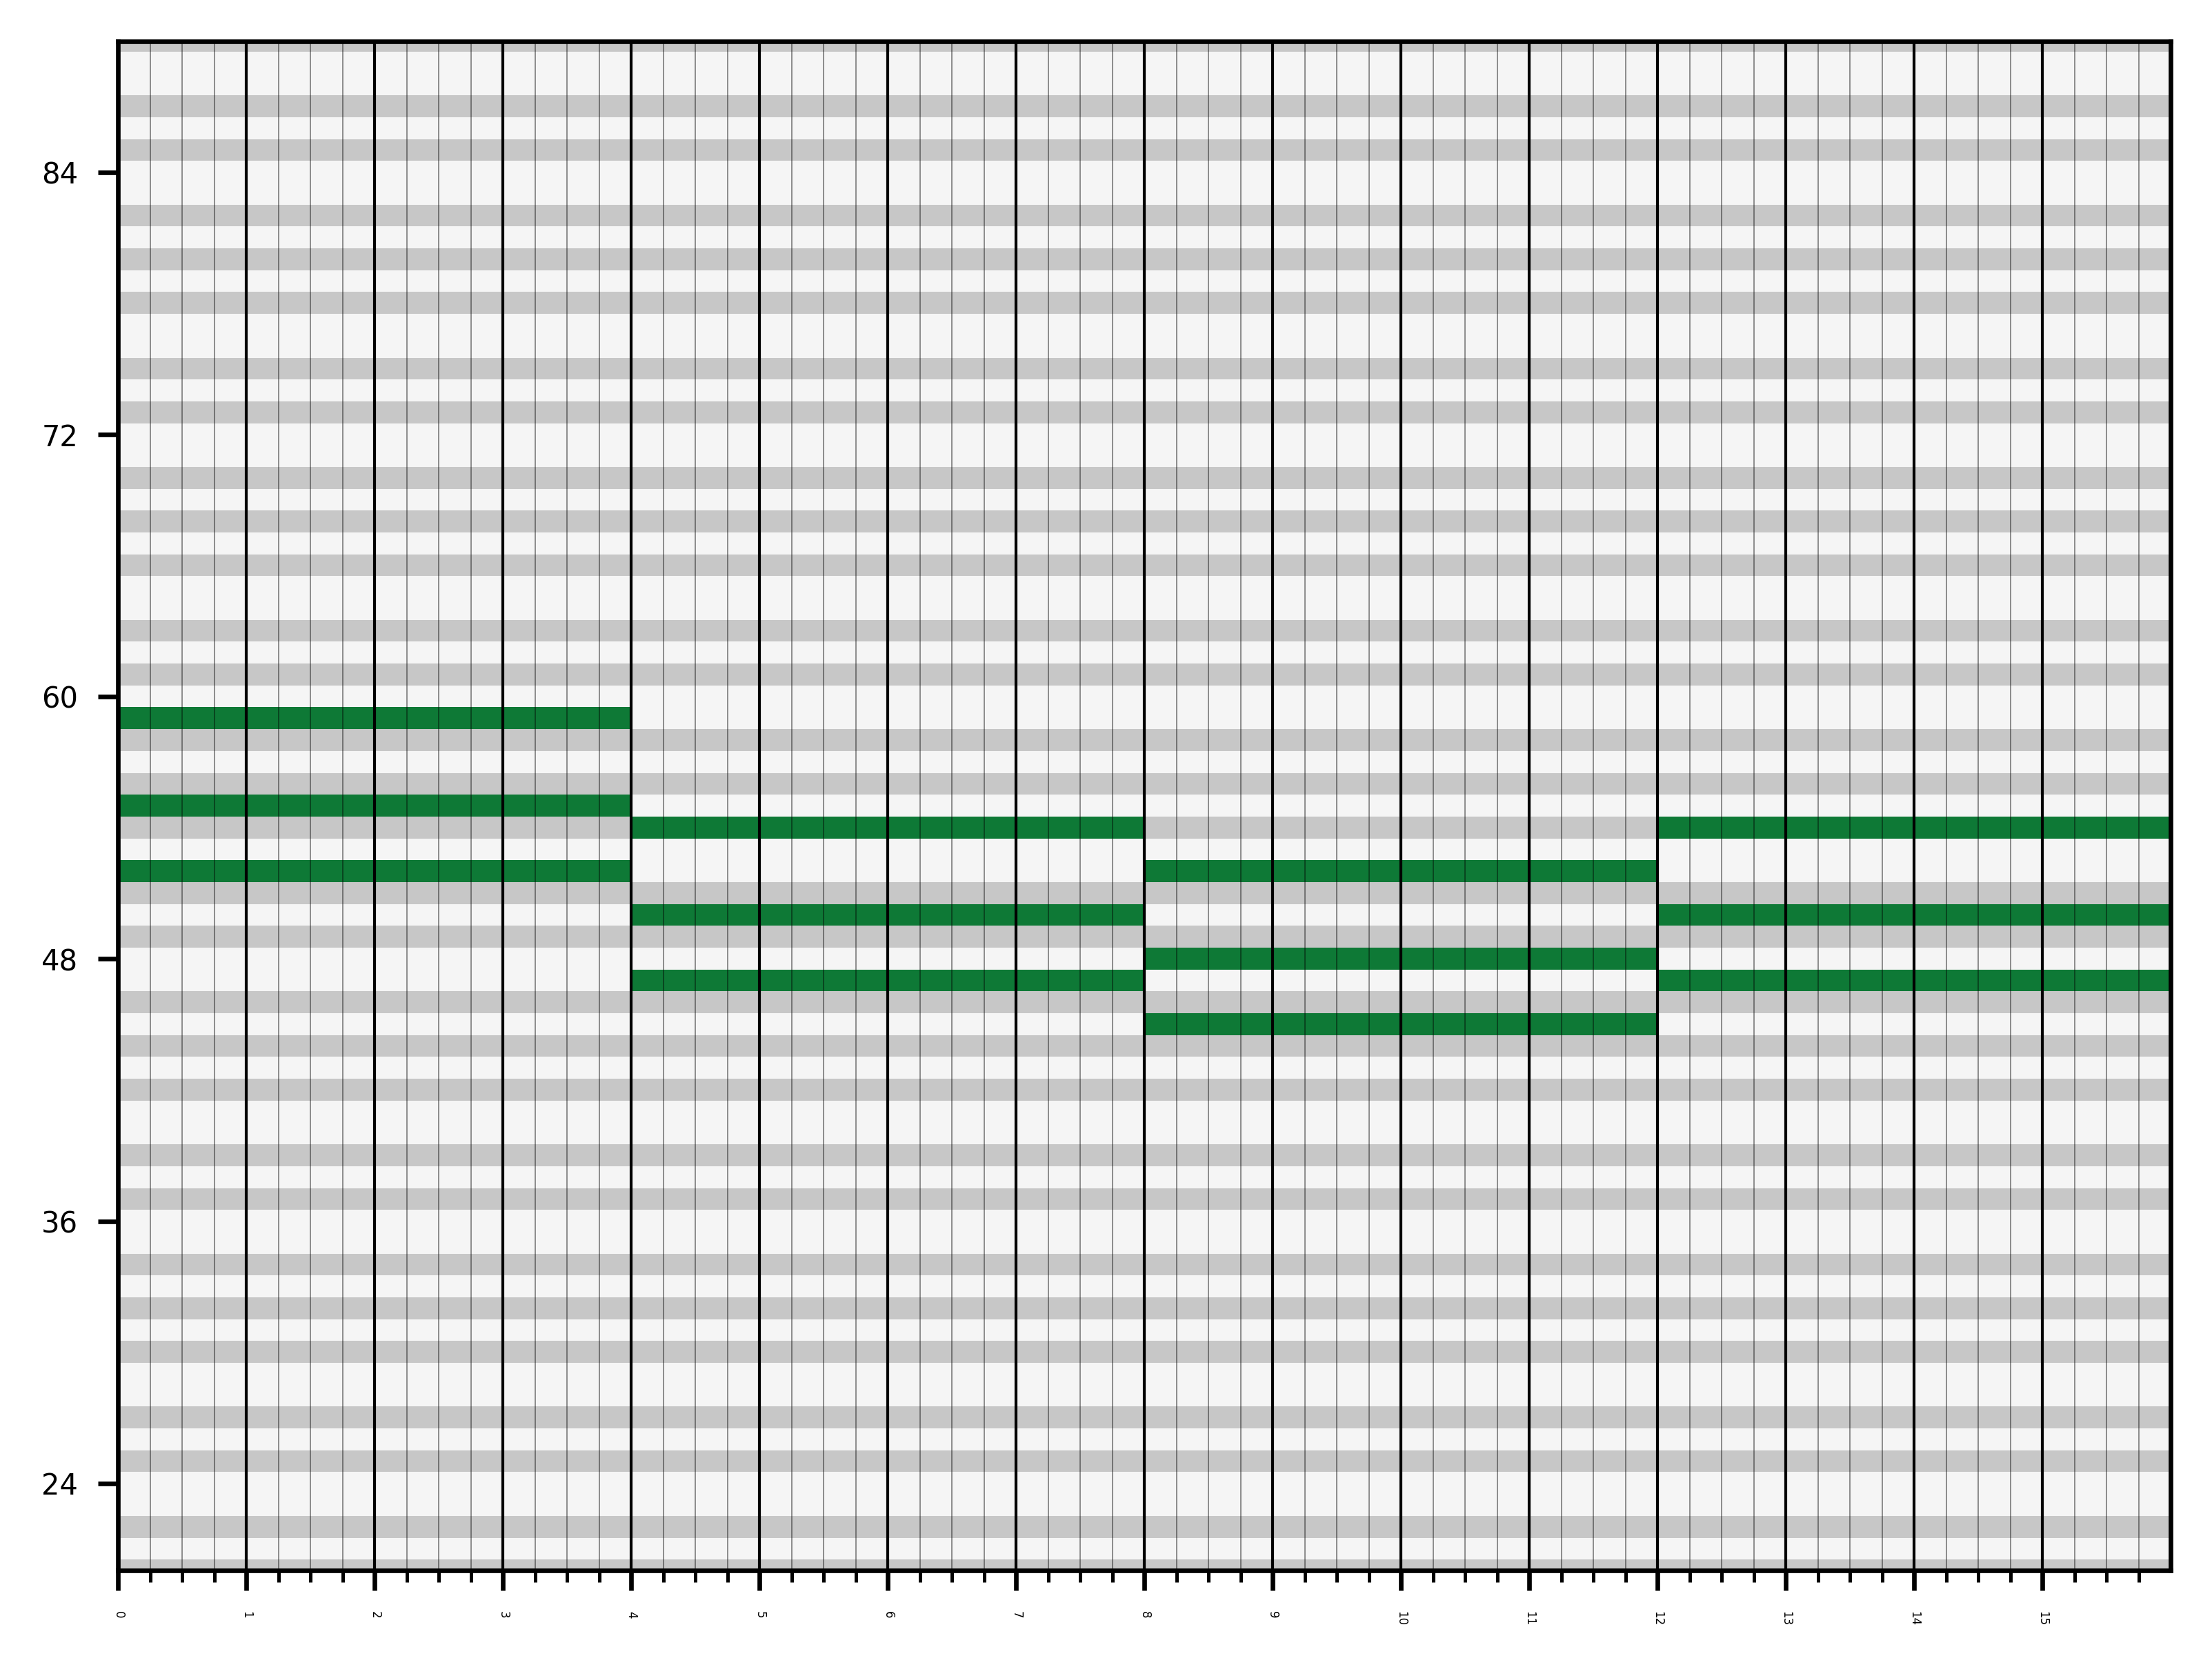

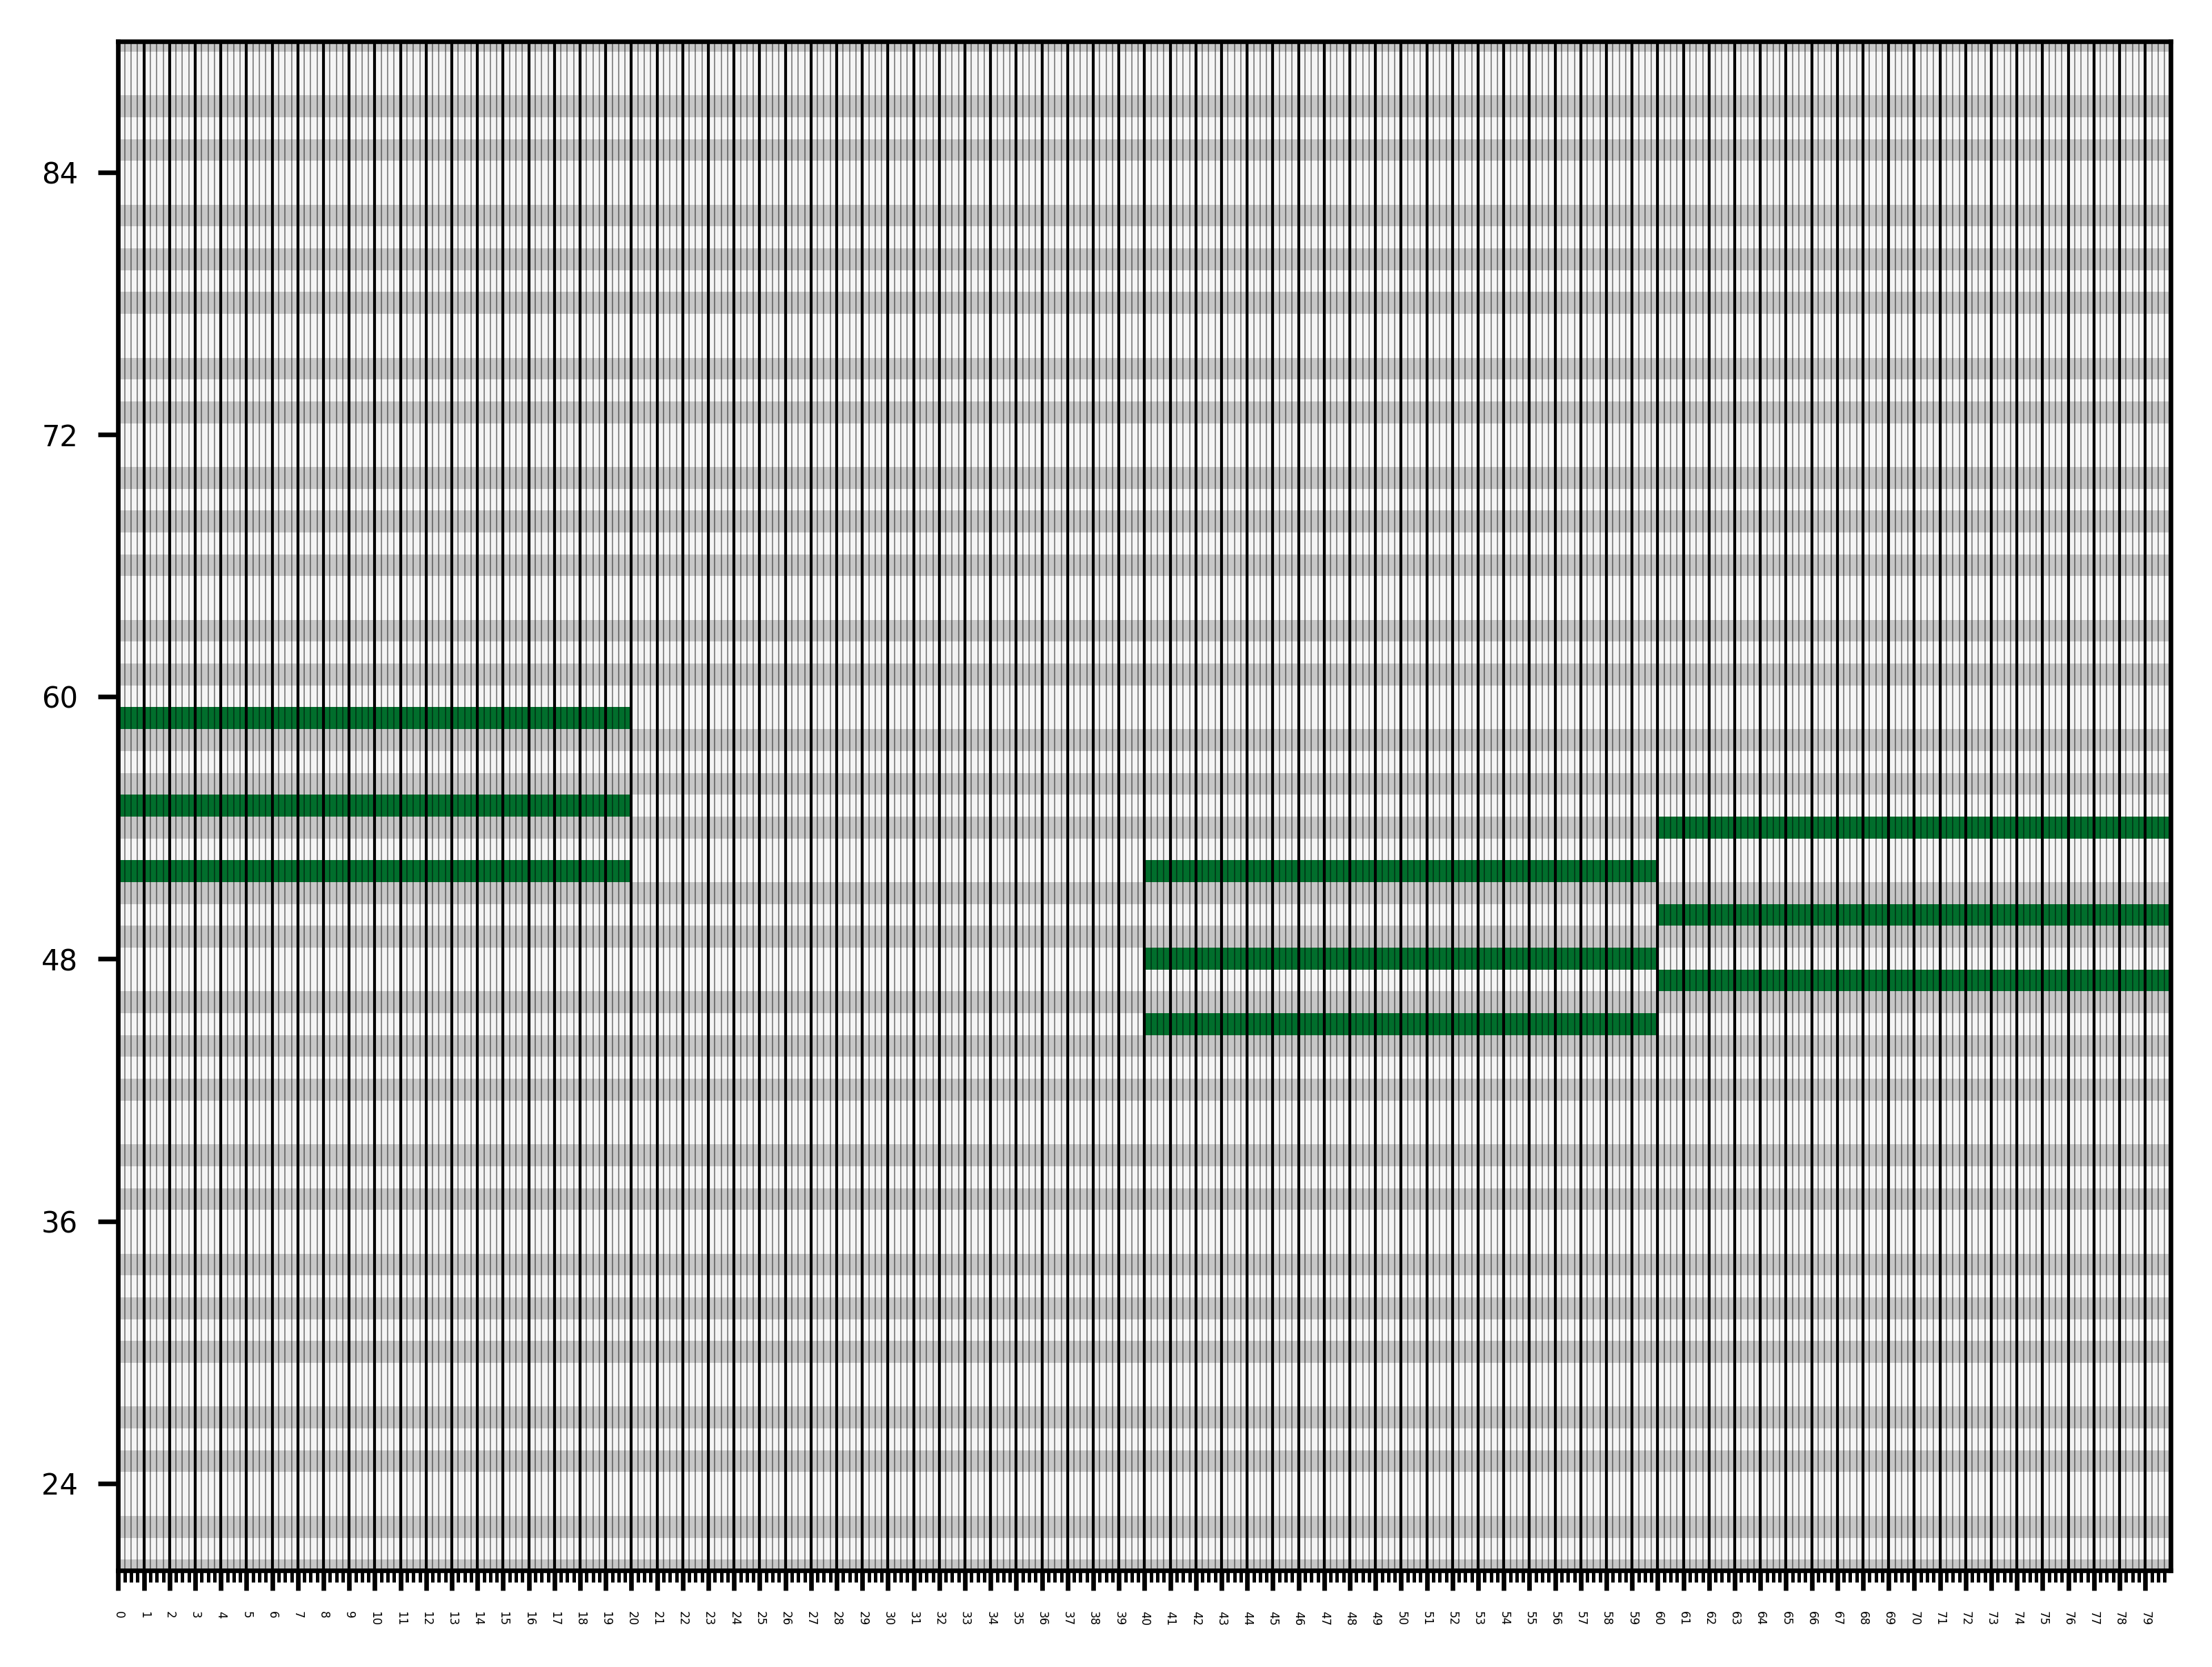

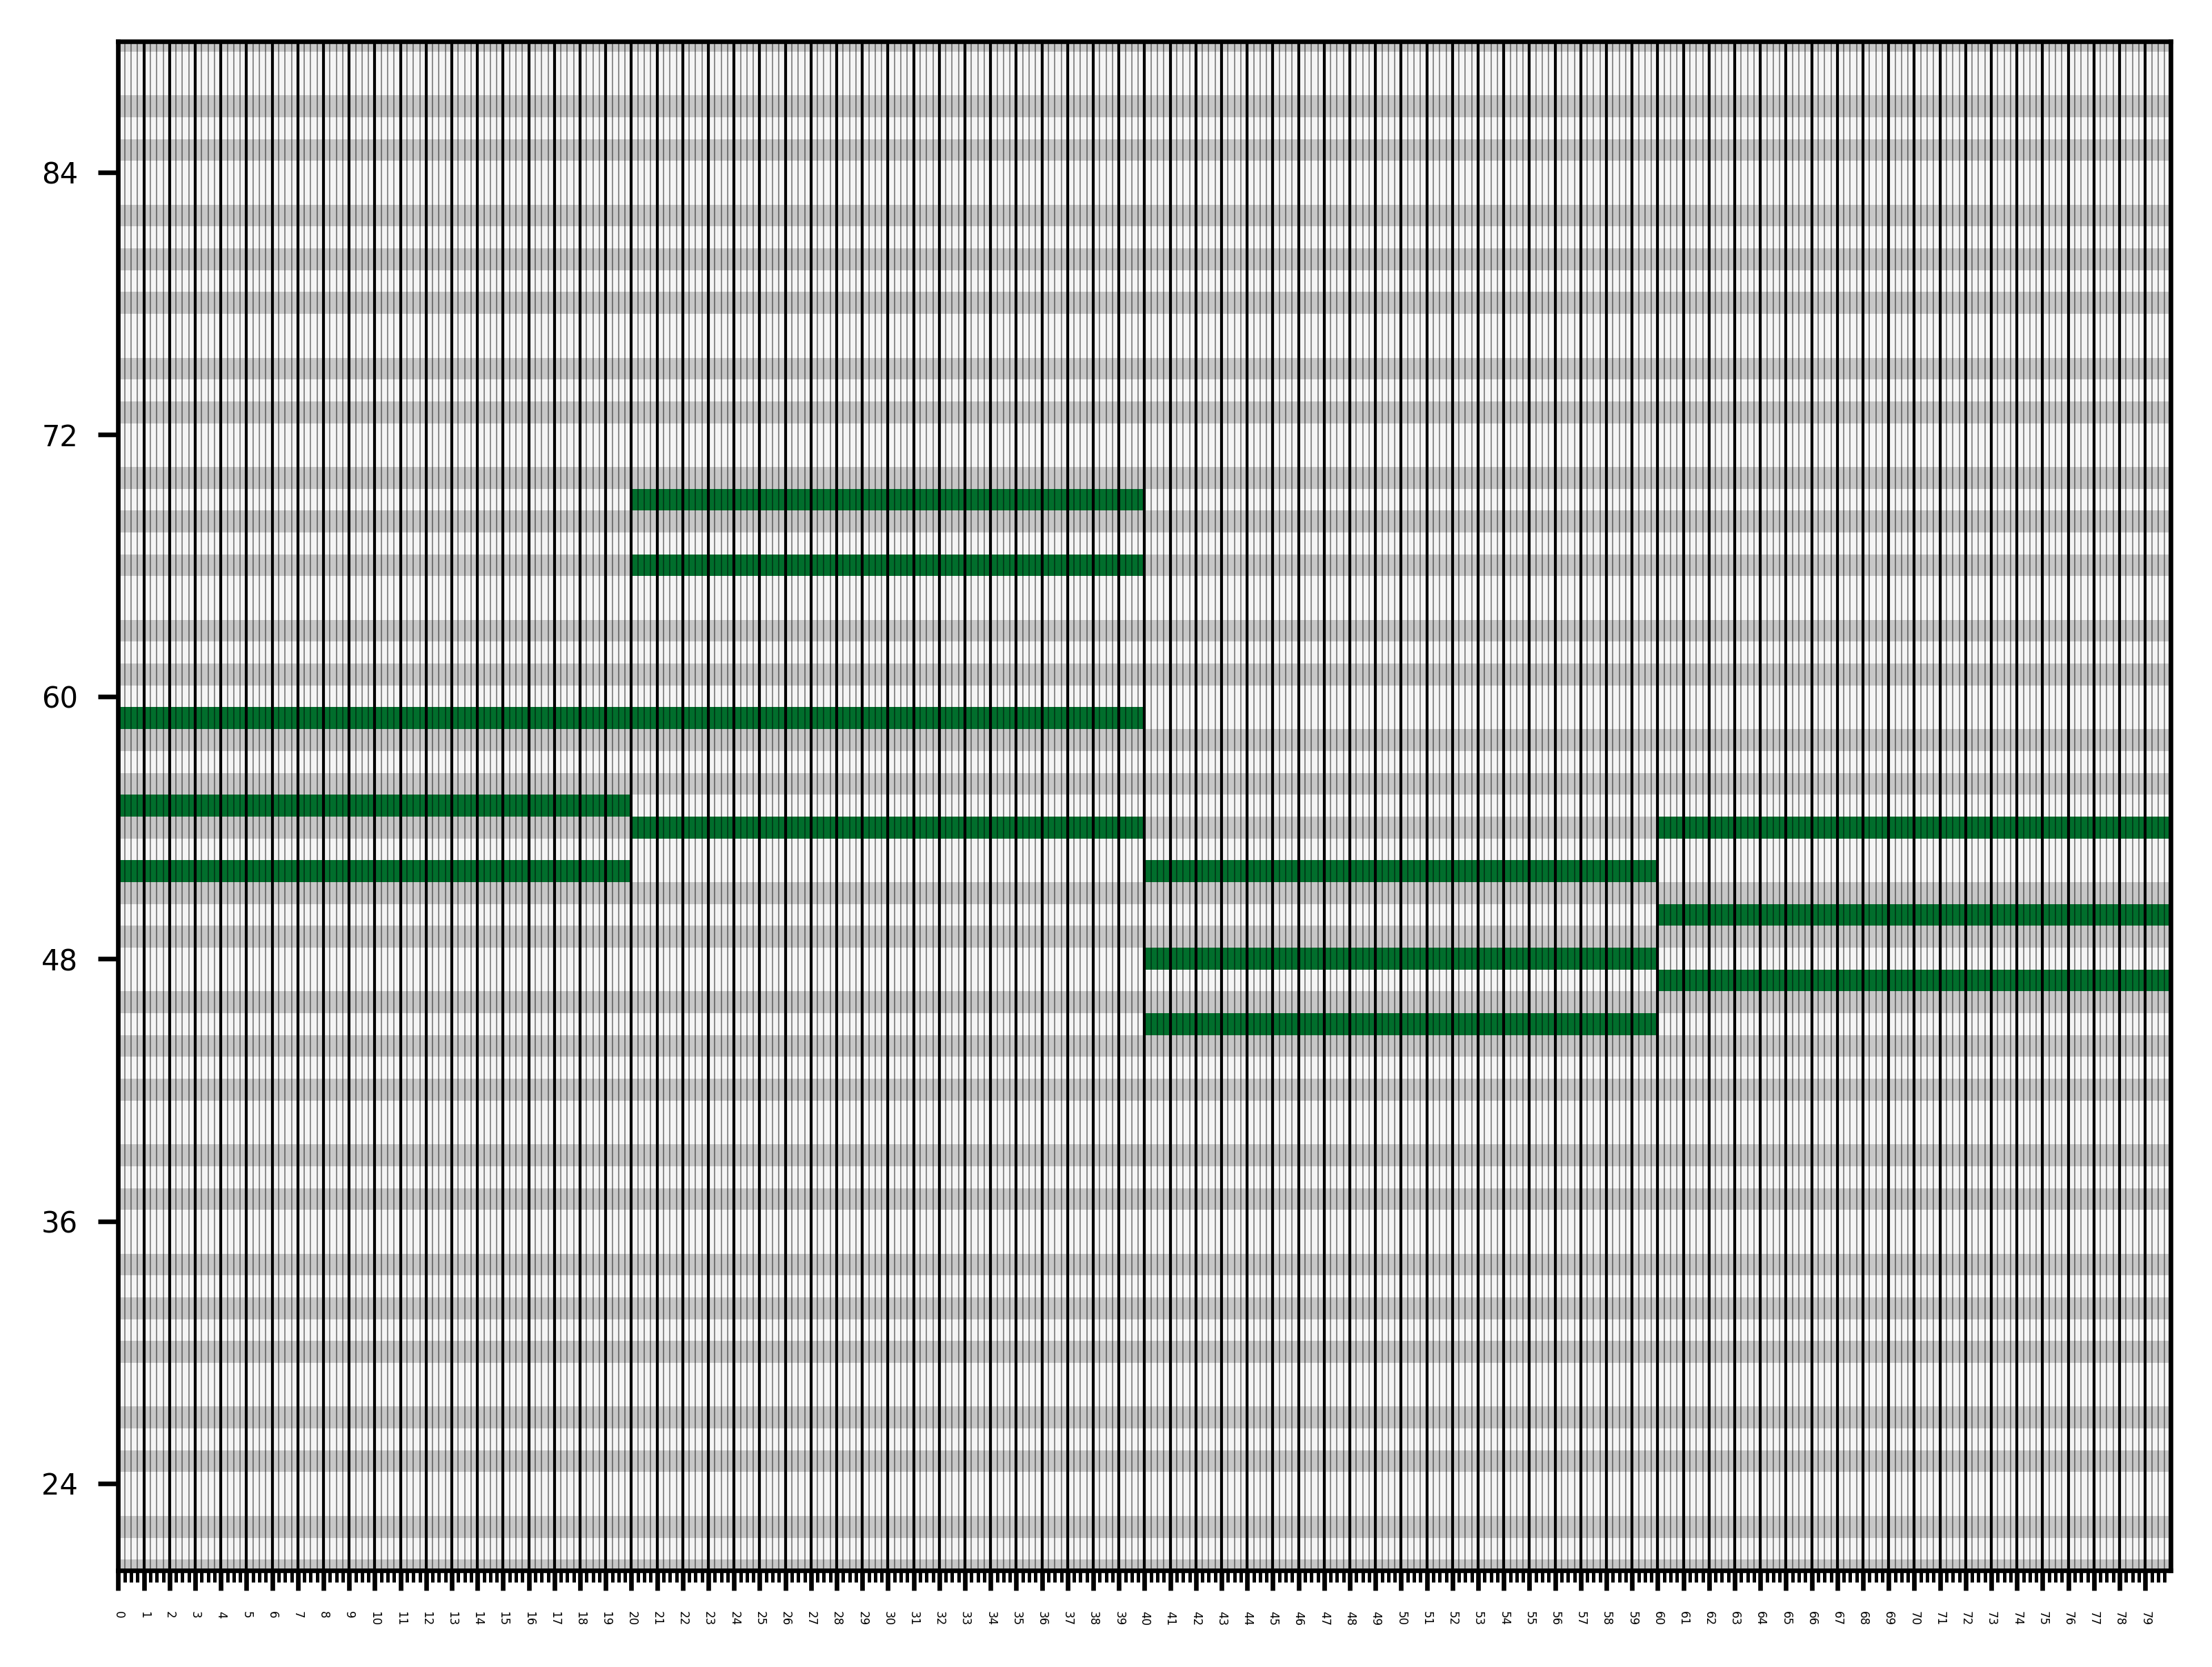

In [5]:
## PREDICTING WITH CHORDTUPLE - Works well with unison
file = "test9"
filename = f'midi/{file}.mid'
inst = 0 # For now only piano
pitchrange = (20, 80) # Want to filter notes within this range

# Get objs
m21_midi = music21.converter.parse(filename)
midi = miditoolkit.midi.parser.MidiFile(filename) # Get file info

chords = chord_preprocess.get_chords(m21_midi, eval=True)
if chords is None:
    raise Exception(f"Could not find good chord progression in this MIDI file.")

# Predictions:
mask_zones=[(1, 2)]
# mask_zones=[(0,1), (2,3)]

for m in mask_zones:
    midi = complete_chord_prog_chordtuple(chords, m[0], m[1],
                                          inst, midi=midi, plot=True, pitchrange=pitchrange)
print("--\nPlots:\n1. Original input MIDI\n2. Masked MIDI zone\n3. Predicted MIDI\n--")
    
# Export result
save = f"{filename.split('.')[0]}_remixed_exp3.mid" # e.g. test1.mid -> test1_remixed_exp1.mid"
midi.dump(save)

<h1>Evaluation

<h3>Supporting Functions</h3>

In [6]:
# find key of file
from music21 import *
def get_key(file):
    f = converter.parse(file)
    k = f.analyze('key')
    if k.mode == "major":
        return k
    elif k.mode == "minor": # Force Major for consistency
        return k.relative
    else:
        return None

In [7]:
# Function for pitch values in a key
def is_in_key(pitch, diff):
    pitch += diff # Transpose to C
    c_major_scale = {0, 2, 4, 5, 7, 9, 11} 
    c_root = 60  # Middle C (C4) as the reference
    pitch_class = (pitch - c_root) % 12 # Copmare with C major
    return pitch_class in c_major_scale

In [8]:
import os, random
debug = False # Change to visualise process

root = "midi/evalution_samples"
test_files = os.listdir(root)
random.shuffle(test_files)
pitchrange = (20, 80) # Want to filter notes within this range
n = 0 # Counter for files
notes = dict()

# TopK Averaging
max_topk = 5
ks = dict()
for k in range(1, max_topk + 1):
    ks[k] = [] # Initialise with empty array
    notes[k] = 0
    
for filename in test_files:
    # Setup
    filename = f"{root}/{filename}"
    
    # Get key
    key = get_key(filename)
    # Get difference from C
    i = interval.Interval(key.tonic, pitch.Pitch('C'))
    difference = int(i.cents/100)
    # Get file info
    midi = miditoolkit.midi.parser.MidiFile(filename)
    m21_midi = music21.converter.parse(filename)
    chords = chord_preprocess.get_chords(m21_midi, eval=True) # eval=True so that we don't actively try and get a "good" chord progression, we just run with whatever the input is.
    
    for k in range(1, max_topk + 1):
        # Randomly mask and predict
        mask_start = random.randint(0, 3)
        mask_end = mask_start + 1
        _, predictions = complete_chord_prog_chordtuple(chords, mask_start, mask_end, 
                                                        inst, topk=k, midi=midi, pitchrange=pitchrange, 
                                                        plot=False, return_pitchnums=True, log=debug) # Don't need returned midi
        
        if len(predictions) == 0: # Sometimes with random masking no chords are masked, so no predictions are made
            continue
        
        # Find percentage of in-key preds
        hits = []
        for p in predictions:
            inkey = is_in_key(p, difference)
            val = 1 if inkey else 0
            hits.append(val)

        perc = round(sum(hits)/len(hits) * 100, 2) # k predictions
        ks[k].append(perc) # Add performance for this k
        notes[k] += len(predictions) # Number of preds made
        
        if debug:
            print(f"\n--\nFile: {filename}")
            print(f"key: {key}")
            print(f"k: {k}")
            print(f"diff: {difference}")
            print(f"preds: {predictions}")
            print(f"ks: {ks}")
            print(f"notes: {notes}")
    n += 1

# Analysis
sum_tot = len_tot = 0
for k in range(1, max_topk + 1):
    k_sum = sum(ks[k])
    k_len = len(ks[k])
    perc = round(k_sum/k_len, 1)
    
    print(f"\nIN-KEY Predictions for TopK = {k}:\n-- {perc}% of {notes[k]} predicted notes across {n} files were in-key.")
    sum_tot += k_sum
    len_tot += k_len

print(f"\nAverage across all K: {round(sum_tot/len_tot, 2)}")


IN-KEY Predictions for TopK = 1:
-- 73.2% of 58 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 2:
-- 71.6% of 64 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 3:
-- 75.2% of 71 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 4:
-- 66.9% of 74 predicted notes across 16 files were in-key.

IN-KEY Predictions for TopK = 5:
-- 70.2% of 72 predicted notes across 16 files were in-key.

Average across all K: 71.42
